# Visualizing Conv filters using ActivationMaximization

## Preparation

### Install libraries

At first, when you didn't yet installed `tf-keras-vis` in your environment such Google Colab, please run the cell below.

In [ ]:
!pip install --upgrade tf-keras-vis tensorflow matplotllib

### Load libraries

In [2]:
%reload_ext autoreload
%autoreload 2

import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

import tensorflow as tf
from tf_keras_vis.utils import num_of_gpus

_, gpus = num_of_gpus()
print('{} GPUs'.format(gpus))

0 GPUs


### Load tf.keras.Model

This tutorial use VGG16 model in tf.keras but if you want to use other tf.keras.Models, you can do so by modifing section below.

In [3]:
from tensorflow.keras.applications.vgg16 import VGG16 as Model

# Load model
model = Model(weights='imagenet', include_top=True)
model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

## Visualizing a Conv filter

### Define a function to modify the model

Define modifier to replace the model output to target layer's output that has filters you want to visualize.

In [4]:
layer_name = 'block5_conv3' # The target layer that is the last layer of VGG16.

def model_modifier(current_model):
    target_layer = current_model.get_layer(name=layer_name)
    new_model = tf.keras.Model(inputs=current_model.inputs,
                               outputs=target_layer.output)
    new_model.layers[-1].activation = tf.keras.activations.linear
    return new_model

### Create ActivationMaximization Instnace

If `clone` argument is True(default), the `model` will be cloned, so the `model` instance will be NOT modified, but it takes a machine resources.

In [5]:
from tf_keras_vis.activation_maximization import ActivationMaximization

activation_maximization = ActivationMaximization(model,
                                                 model_modifier,
                                                 clone=False)

### Define Loss function

You MUST define Loss function that return arbitrary filter values. Here, it returns the value corresponding third filter in `block5_conv3` layer. ActivationMaximization will maximize the filter value.

In [6]:
filter_number = 3
def loss(output):
    return output[..., filter_number]

### Visualize

ActivationMaximization will maximize the model output value that is computed by the loss function. Here, we try to visualize a convolutional filter.

Steps: 050	Losses: [[377.6980895996094]],	Regularizations: [('TotalVariation', 106.42388153076172), ('L2Norm', 0.025522906333208084)]
Steps: 100	Losses: [[526.3512573242188]],	Regularizations: [('TotalVariation', 123.88922882080078), ('L2Norm', 0.02533346228301525)]
Steps: 150	Losses: [[597.1829833984375]],	Regularizations: [('TotalVariation', 129.49017333984375), ('L2Norm', 0.025195151567459106)]
Steps: 200	Losses: [[693.4005737304688]],	Regularizations: [('TotalVariation', 138.18179321289062), ('L2Norm', 0.025078635662794113)]


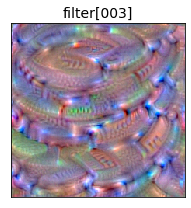

CPU times: user 13min 57s, sys: 2min 3s, total: 16min
Wall time: 11min 4s


In [7]:
%%time
from tf_keras_vis.utils.callbacks import Print

# Generate max activation
activation = activation_maximization(loss,
                                     callbacks=[Print(interval=50)])
image = activation[0].astype(np.uint8)

# Render
subplot_args = { 'nrows': 1, 'ncols': 1, 'figsize': (3, 3),
                 'subplot_kw': {'xticks': [], 'yticks': []} }
f, ax = plt.subplots(**subplot_args)
ax.imshow(image)
ax.set_title('filter[{:03d}]'.format(filter_number), fontsize=14)
plt.tight_layout()
plt.show()

## Visualizing Conv filters

Then, let's visualize multiple convolutional filters!

### Define Loss function

When visualizing multiple convolutional filters, you MUST define Loss function that return arbitrary filter values for each layer.

In [8]:
filter_numbers = [63, 132, 320]

# Define loss function that returns multiple filter outputs.
def loss(output):
    return (output[0, ..., 63], output[1, ..., 132], output[2, ..., 320])

### Create SeedInput values

And then, you MUST prepare seed-input value. In default, when visualizing a conv filter, tf-keras-vis automatically generate seed-input for generating a image. When visualizing multiple conv filters, you MUST manually generate seed-input whose samples-dim is as many as the number of the filters you want to generate.

In [9]:
# Define seed inputs whose shape is (samples, height, width, channels).

seed_input = tf.random.uniform((3, 224, 224, 3), 0, 255)

### Visualize

Here, we will visualize 3 images while `steps` option is to be 512 to get clear images.

Steps: 050	Losses: [[502.71014404296875, 395.36578369140625, 546.4747314453125]],	Regularizations: [('TotalVariation', 43.58282470703125), ('L2Norm', 0.014687128365039825)]
Steps: 100	Losses: [[770.85986328125, 520.707763671875, 697.3626708984375]],	Regularizations: [('TotalVariation', 48.56857681274414), ('L2Norm', 0.014562087133526802)]
Steps: 150	Losses: [[778.276123046875, 595.3997802734375, 742.9821166992188]],	Regularizations: [('TotalVariation', 49.88611602783203), ('L2Norm', 0.014472165144979954)]
Steps: 200	Losses: [[900.8142700195312, 826.8975830078125, 909.9053955078125]],	Regularizations: [('TotalVariation', 57.01945495605469), ('L2Norm', 0.014375065453350544)]


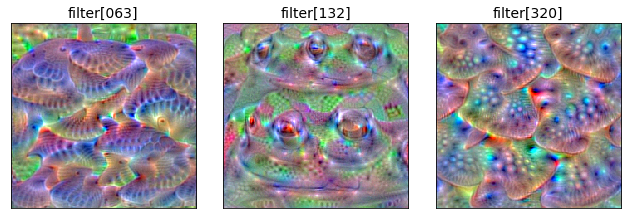

CPU times: user 41min 29s, sys: 3min 47s, total: 45min 16s
Wall time: 27min 44s


In [10]:
%%time

# Generate max activation
activations = activation_maximization(loss,
                                      seed_input=seed_input, # To generate multiple images
                                      callbacks=[Print(interval=50)])
images = [activation.astype(np.uint8) for activation in activations]

# Render
subplot_args = { 'nrows': 1, 'ncols': 3, 'figsize': (9, 3),
                 'subplot_kw': {'xticks': [], 'yticks': []} }
f, ax = plt.subplots(**subplot_args)
for i, filter_number in enumerate(filter_numbers):
    ax[i].set_title('filter[{:03d}]'.format(filter_number), fontsize=14)
    ax[i].imshow(images[i])
plt.tight_layout()
plt.savefig('images/visualize-filters')
plt.show()